# EDA

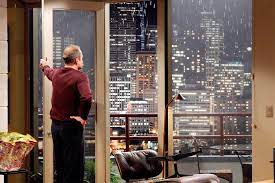

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.2f' % x)


pd.set_option('display.max_columns', 50)

# Stakeholder
Timothy Stevens: Owns expensive houses in the center, needs to get rid, best timing within a year, open for renovation when profits rise.

# Import the data

In [ ]:
df = pd.read_csv("data/King_County_House_prices_dataset.csv")

# Understanding the data


In [ ]:
df.info()
# waterfront and yr_renovated contain NAs
# date needs to be converted
# Better description of columns can be found here: https://geodacenter.github.io/data-and-lab/KingCounty-HouseSales2015/
# Info on Zipcodes: https://gis-kingcounty.opendata.arcgis.com/datasets/zipcodes-for-king-county-and-surrounding-area-shorelines-zipcode-shore-area/explore?location=47.504243%2C-121.477600%2C8.67
# sqft_living15 is the avarage size of living space of the closest 15 neighbours. Will help to determine if a house is bigger compared to neighbors.
# view - An index from 0 to 4 of how good the view of the property was
#condition - An index from 1 to 5 on the condition of the apartment,
#grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

# Research questions + hypotheses and Todo
Stakeholder: Timothy Stevens: Owns expensive houses in the center, needs to get rid, best timing within a year, open for renovation when profits rise.

Question: When is the best timing to sell houses?
Hypothesis: The avarage price varies over the year

Question: Will a recent renovation increase the selling price?
Hypothesis: Houses renovated in the same year have a higher avarage price.

Hypothesis: There is a correlation between grade and price, sqft_living and price.
Hypothesis: View, grade and condition are positively correlated.


Geohypo: Plot a map with $/sqft per zipcode. Hypo: Higher in seattle.


For the EDA:
1. Filter for houses in the center (by zipcode?). What is the center? Seattle?
2. Define 'expensive' (80% quartile?). 




# Data exploration

In [ ]:
#df.hist(column=["price","bedrooms","sqft_living","floors","grade","yr_built","yr_renovated","sqft_living15"],layout=(4,2),figsize=(12,6))

# There are a few very big very very expensive houses
# Filter them for a first glance

#df[df.price < 4000000].hist(column=["price","bedrooms","sqft_living","floors","grade","yr_built","yr_renovated","sqft_living15"],layout=(4,2),figsize=(12,6))

# There seem to be some houses that are very high cost and/or high number of bedrooms, very high number of sqft_living. Maybe outliers? need to check.
# Most houses have not been renovated which is sometimes a 0 and sometimes NaN !

df[df.price > 7000000]
# 45 houses over 3 million
# 2 houses over 7 million

df[df.bedrooms > 10]
# 2 houses with more than 10 bedrooms, 33 bedrooms one is probably a typo because it is not too big.

df[df.sqft_living > 8000]
# 211 houses with over 5k sqft living
# 9 houses with over 8k sqft living. all with high grade and a high price so probably valid data.




# Note: Delete the 33 bedroom one, apart from that all looks 'normal'



# Feature engineering

In [ ]:
# Seattle column. 

# Zip codes for seattle
#sorted(df.zipcode.unique())

# Seattle Zipcodes range from 98101-98199 (only 64 are taken)(https://www.zipcode.com.ng/2022/12/seattle-zip-codes-wa.html)

df["seattle"] = df.zipcode.between(98101,98200)
df.groupby("seattle").mean()

# Interestingly the avarage price does not differ, but houses within Seattle are smaller, with fewer bed and bathrooms and the lot is much smaller.




In [ ]:
# Price per sqft


df["price_sqft_liv"] = df.price / df.sqft_living
df["price_sqft_lot"] = df.price / df.sqft_lot
df.groupby("seattle").mean()

# Price per sqft is higher in seattle compared to the outskirts. However, the difference is even higher for the lot price.


In [ ]:
# Center = Seattle might not be the best definition.
# Alternatively, I will use the Top10 Zipcodes with the highest population density according to: http://www.usa.com/rank/king-county-wa--population-density--zip-code-rank.htm?yr=9000&dis=&wist=&plow=&phigh=
# I just saw that the top2 ZipCodes only have a population of 70 people and are admin buildings. So I take Top3-Top12
df["center"] = df.zipcode.isin([98119,98117,98121,98101,98104,98102,98122,98109,98107,98103])

df.groupby(["seattle","center"]).mean()
# Very cool. Price per sqft rises from rural -> seattle -> center

In [ ]:
# What is expensive?
# Upper 20% ?!
# To check if general assumptions hold true for expensive houses (like Tim owns them) as well.
df["expensive"] = pd.qcut(df.price,5,[1,2,3,4,5])

# Data Cleaning

In [ ]:
# Drop the 33 bedroom row.
df = df[df.bedrooms < 33]

# get the date right
df["date"] = pd.to_datetime(df.date, format= '%m/%d/%Y')

## year renovated has some strange data according to the histograms
#df.yr_renovated 
# Seems that non-renovated houses either have a NaN or a 0. Convert 0 to NaN
df["yr_renovated"] = df["yr_renovated"].replace(0,np.nan)
df["yr_renovated"].hist() # Looking better now.

print(df.date.dtypes)


# Correlations


In [ ]:
# 1. condition, view and grade
df[["grade","view","condition","seattle"]].groupby("seattle").corr()
# Grade and view are marginally correlated, but condition isn't. Might be worth to deepdive in what exactly they mean.
# View = quality der Besichtigung???
# Grade = How well is it constructed?
# Condition = Wie gut ist es in Schuss?!

# What influences the price?
df[["grade","view","condition","seattle"]].groupby("seattle").corr()
corr_mat_price = df.drop(["id","date","waterfront","zipcode","lat","long","seattle"],axis=1).corr()
sns.heatmap(corr_mat_price[["price"]], cmap="viridis")
corr_mat_price[["price"]]
# Factors influencing the price (> 50%)
# Bathrooms, sqft-living, grade, sqft_above, sqft_living15
# However, yr_renovated doesnt make sense without changing it!!!


### Note: Scatter
corr_mat_price

# Answering research questions
# 1. How does selling price fluctuate over the year

In [ ]:
df.date.value_counts() # there are days with only 1 sale per day so might not be a good idea to aggregate per day.
df.date.dt.week.value_counts() # looks better

# However there is some overlap in May. So lets make a better week column.
df.date.describe()
df["week"] = (df["date"] - pd.to_datetime("2014-05-02")).dt.days // 7 + 1

df.week.value_counts() # Almost no data in the last two weeks. Get rid of it, since we have data on the timespan of 1 year.

df_weekly = df[df.week < 55]

df_weekly.groupby("week").mean("price_sqft_liv").reset_index().plot.line(x="week",y="price_sqft_liv")
# A lot of week to week variation and generally speaking the avg sales price varies by up to 15% depending on time.
# It seems like Sale prices in weeks 48 - 54 are a bit higher which would be End of March - Beginning of July 

# Lets check data on that assumption:
df_weekly["high_price"] = df_weekly.week.isin(list(range(48,55)))
df_weekly.groupby("high_price").mean()
# The avarage selling price in the above mentioned time span is 20$/sqft higher. However, the high week2week variation needs to be considered.
# Also this trend was only true in 2015. So something else might have triggered it.
# But generally the first half of the year seems to be better suited.
df_weekly["firsthalf"] = df_weekly.date.dt.month.isin([1,2,3,4,5,6])
df_weekly.groupby("firsthalf").price_sqft_liv.mean()







# Follow up.
# Does this hold true for the center as well????




In [ ]:
# Is this true for center and/or expensive houses as well?
df_weekly_cent = df_weekly[(df_weekly.center == True)] #2107
df_weekly_cent.groupby("week").mean("price_sqft_liv").reset_index().plot.line(x="week",y="price_sqft_liv") # Same 2015 increase trend


df_weekly_exp = df_weekly[(df_weekly.expensive == 5)] #4319
df_weekly_exp.groupby("week").mean("price_sqft_liv").reset_index().plot.line(x="week",y="price_sqft_liv") # Same 2015 increase trend



# 2. Does a recent renovation increase the selling price?

In [ ]:
# Things to consider: Drop recently built houses since they will have a high selling price and no renovation yet.
# Lets randomly go up to yr_built 2000 and define recently as "within the last 5 years". DOESNT REALLY INFLUENCE IT.
df_reno = df

sorted(df_reno.yr_renovated.unique()) #even some renovated in 2015
df_reno.yr_renovated.value_counts() # Wow, most were renovated in 2014

df_reno["recent_reno"] = df_reno.yr_renovated.isin([2010,2011,2012,2013,2014,2015])
sum(df_reno["recent_reno"]) # 150

# The number is relatively low but let's see what it does:
df_reno.groupby("recent_reno").mean() # The price is higher even after correcting for the difference in sqft_living (see price per sqft).
# There seems to be a high demand for newly renovated houses.

# Lets compare it with houses that were never renovated
# But be careful we don't know if initial NaN values mean no renovation of if its reno_date is unknown.

df_reno["renovated"] = ~df_reno.yr_renovated.isna() # The ~ reverts True and False apparently.
df_reno.groupby("renovated").mean()
# A renovation no matter if recent or not increases the avarage sale price.

df_reno.groupby(["renovated","recent_reno"]).mean()
# The main difference (price / sqft) is between no renovated and renovated. a recent_renovation only rises the price every to slightly.
# Timothy should therefore only renovate those houses that have never been renovated.
pd.pivot_table(df_reno, values="price_sqft_liv", index="renovated", columns="recent_reno")




# Further question:
# Is there a yr_renovated threshold were the price of renovated == unrenovated, No there isnt!

# Do the groupby in pivot_table

# Careful because of lower n. 744 renovated.

# check again if 0 = NaN or if it can be split further. See bottom.


In [ ]:
# Calculate mean of unrenovated houses in expensive=5 bucket, create qcut-bins for the renovated houses for the yr column and check their mean prices

df_reno[(df_reno.renovated == False) & (df_reno.expensive == 5)].price_sqft_liv.mean() # 346$

df_reno[(df_reno.renovated == True)  & (df_reno.expensive == 5)].shape # Only 313 renovated in expensive = 5. Will be further devided by qcut. Grain of salt!

df_reno_exp = df_reno[(df_reno.renovated == True)  & (df_reno.expensive == 5)]

df_reno_exp["reno_bin"] = pd.qcut(df_reno_exp.yr_renovated,5)

df_reno_exp.groupby("reno_bin").price_sqft_liv.mean()


# A renovation no matter when makes a house more expensive!


In [ ]:
df_reno.groupby(["renovated","expensive"]).size()

# Expensive houses are more often renovated
# Or:
# Houses GET expensive after renovation.

# Careful does not hold true for center house !!!

In [ ]:

df_reno.groupby("renovated").price_sqft_liv.mean() #262.10 vs 321.34 $/sqft
df_reno.query("expensive == 5").groupby("renovated").size()                         #4k vs 313
df_reno.query("center == True").groupby("renovated").size()                         #1k vs 116
df_reno.query("center == True & expensive == 5").groupby("renovated").size()        #515 vs 67

df_reno.query("expensive == 5").groupby("renovated").price_sqft_liv.mean()                         #345 vs 404
df_reno.query("center == True").groupby("renovated").price_sqft_liv.mean()                      #381 vs 378
df_reno.query("center == True & expensive == 5").groupby("renovated").price_sqft_liv.mean()       #411 vs 403



###### What if we go back to our center = Seattle definition?
df_reno.query("seattle == True").groupby("renovated").price_sqft_liv.mean() 
#df_reno.query("seattle == True").groupby("renovated").price_sqft_liv.mean() 
#df_reno.query("seattle == True & expensive == 5").groupby("renovated").price_sqft_liv.mean() 

#pd.pivot_table(df_reno,values="price_sqft_liv",index="renovated",columns=["expensive","seattle"], margins=True, aggfunc="mean")

#df_reno.query("expensive == 5").groupby("renovated").price_sqft_liv.mean()    
#df_reno.query("center == True & expensive == 5").groupby("renovated").price_sqft_liv.mean()           

Decisions made:

1. yr_renovated 0 -> NaN.
I first thought that rows containing a 0 might mean 'not renovated' and NaN could mean 'renovated but unsure when'.
But when I looked closer at those houses with NaN I found that some of them were built only very recently and I think it is safe to assume that they haven't been renovated yet. Therefore I decided to group 0s and NaNs together as 'not renovated', or at least not recently renovated which is important for my client.
Additionally the price_sqft_liv is not too different between those two groups: 261 vs 265



# Plots

In [ ]:
df.price_sqft_liv.mean()

In [ ]:
# Time Series
from scipy.stats import iqr

grpweek = df_weekly.groupby("week")
df_weekplot = grpweek.mean("price_sqft_liv").reset_index()
#df_weekplot_sd = df_weekly.groupby("week").iqr("price_sqft_liv").reset_index()

#grpweek = df_weekly.groupby("week")
df_weekplot["iqr"] = grpweek.quantile(0.40).reset_index().price_sqft_liv - grpweek.quantile(0.50).reset_index().price_sqft_liv

#print(df_weekplot)

fig = plt.figure(figsize=(15,7))

plt.title("Avg. price per sqft living space over the year",  fontsize = 18)
#plt.xlim(0.5,3.5)
#plt.ylim(0,440)
#plt.xticks([1,2,3],["All price classes, King County", "Expensive, King County", "Expensive, Center"], fontsize = 16)
#plt.yticks(fontsize = 16)
#plt.ylabel("Price per sqft living space", fontsize = 16)

plt.plot(df_weekplot.week, df_weekplot.price_sqft_liv, c = "blue",linewidth=3)
plt.fill_between(df_weekplot.week, df_weekplot.price_sqft_liv + df_weekplot.iqr, df_weekplot.price_sqft_liv - df_weekplot.iqr, alpha=0.5,color="lightblue")

plt.xlim(0,55)
plt.ylabel("Price per sqft living space", fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)

plt.xticks([1,18,36, 54],["May 2014", "September 2014", "January 2015", "May 2015"], fontsize = 16)

plt.axhline(y = 264, color='r', linestyle = "dotted", alpha = 0.8)



In [ ]:
# Renovations
fig = plt.figure(figsize=(15,5))

plt.title("Avg. price per sqft living space in renovated vs unrenovated houses",  fontsize = 18)
plt.xlim(0.5,3.5)
plt.ylim(0,440)
plt.xticks([1,2,3],["All price classes, King County", "Expensive, King County", "Expensive, Center"], fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Price per sqft living space", fontsize = 16)


# Bar 1
plt.bar(x = 1, height = 262.10, color = 'r', label = "not renovated")
plt.bar(x = 1, height = 321.34 - 262.10, bottom = 262.10, color = "b", label = "renovated")
plt.text(1, 331, "+ 18 %", va="center", ha="center", weight = "bold", fontsize = 16)

# Bar 2
plt.bar(x = 2, height = 345.86, color = 'r')
plt.bar(x = 2, height = 404.57 - 345.86, bottom = 345.86, color = "b")
plt.text(2, 415.5, "+ 15 %", va="center", ha="center", weight = "bold",  fontsize = 16)

# Bar 3
plt.bar(x = 3, height = 402.89, color = 'b')
plt.bar(x = 3, height = 410.58 - 402.89, bottom = 402.89, color = "r")
plt.text(3, 420, "- 2 %", va="center", ha="center", weight = "bold",  fontsize = 16)

legend = plt.legend(frameon=False, ncol=2,loc = "center", fontsize = 16)
legend.set_bbox_to_anchor((0.5, -0.13))






# 3. Price sqft in relation to size

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# Check if the relationship between price sqft and size is linear or quadratic

# Filter for expensive and center
df_expcen = df.query("center == True & expensive == 5 & sqft_living < 7500")

#df_expcen.plot.scatter("sqft_living","price_sqft_liv")

# The lower boundary/isocline is created artificially. Everything below would be put into expensive = 4 category.
# However, it shows the minimum price Timothy should ask for IF his apartments are really to be considered good/expensive (i.e. in the top-20%)
# From the limited amount of data we have it seems that people who want to buy really big houses are willing to pay above-avg price_sqft!


fig = plt.figure(figsize=(15,7))

plt.title("Price per sqft living space vs the available living space for expensive houses in the center",  fontsize = 18)
#plt.xlim(0.5,3.5)
#plt.ylim(0,440)
#plt.xticks([1,2,3],["All price classes, King County", "Expensive, King County", "Expensive, Center"], fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.xlabel("Living space in square foot", fontsize = 16)
plt.ylabel("Price per square foot living space", fontsize = 16)

plt.scatter(df_expcen.sqft_living, df_expcen.price_sqft_liv)


# Make spline / smooth line
from scipy.interpolate import interp1d

#x = np.array([950, 1420, 2000, 3000, 4000,4400])
#y = np.array([780, 480, 345, 240, 180,165])

x = np.linspace(950,4500,3550)
#y = 4101.93 - 1720.91*(x**0.10004)

y = (1140550635652613*𝑥**6/353416063178198154960000000000000)-(113391156678593029*𝑥**5/1860084543043148184000000000000)+(41918112865053924659*𝑥**4/88354015794549538740000000000)-(6895232119610205030013*𝑥**3/3534160631781981549600000000)+(388030040033649492163*𝑥**2/86199039799560525600000)-(2502634408052936702897*𝑥/441770078972747693700)+(265855351398709790960/77503522626797841)

#cubic_interpolation_model = interp1d(x, y, kind = "cubic")

# Plotting the Graph
#X_=np.linspace(x.min(), x.max(), 500)
#Y_=cubic_interpolation_model(X_)
 
plt.plot(x,y, c="red" )

plt.axhline(y = 409, color='r', linestyle = "dotted", alpha = 0.8)

legend_elements = [Line2D([0], [0], color='red', lw=3, label='Lower boundary for "expensive" category'),
                   Line2D([0], [0], color="red", lw=3, linestyle = "dotted", label='Avg. price per sqft')]
legend = plt.legend(handles=legend_elements, loc='center', frameon=False, ncol=2, fontsize = 15.5)
legend.set_bbox_to_anchor((0.5, -0.15))




# Outlook

1. Why is renovation in center not important?

2. Was the increase of prices in May 2015 triggered by something?

In [ ]:
###### Redoing time series but with biweekly or monthly

df.date.value_counts() # there are days with only 1 sale per day so might not be a good idea to aggregate per day.
df.date.dt.week.value_counts() # looks better

# However there is some overlap in May. So lets make a better week column.
df.date.describe()

df_month = df.copy()

df_month["month"] = (df["date"] - pd.to_datetime("2014-05-02")).dt.days // 30 + 1

df_month = df_month[df_month.month < 14]

df_month.month.value_counts() # Almost no data in the last two weeks. Get rid of it, since we have data on the timespan of 1 year.



df_month.groupby("month").mean("price_sqft_liv").reset_index().plot.line(x="month",y="price_sqft_liv")
# A lot of week to week variation and generally speaking the avg sales price varies by up to 15% depending on time.
# It seems like Sale prices in weeks 48 - 54 are a bit higher which would be End of March - Beginning of July 

# Lets check data on that assumption:
#df_month["high_price"] = df_month.week.isin(list(range(48,55)))
#df_month.groupby("high_price").mean()
# The avarage selling price in the above mentioned time span is 20$/sqft higher. However, the high week2week variation needs to be considered.
# Also this trend was only true in 2015. So something else might have triggered it.
# But generally the first half of the year seems to be better suited.
#df_month["firsthalf"] = df_month.date.dt.month.isin([1,2,3,4,5,6])
#df_month.groupby("firsthalf").price_sqft_liv.mean()



In [ ]:
#from scipy.stats import iqr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

grpweek = df_month.groupby("month")
df_weekplot = grpweek.mean("price_sqft_liv").reset_index()
#df_weekplot_sd = df_weekly.groupby("week").iqr("price_sqft_liv").reset_index()

#grpweek = df_weekly.groupby("week")
df_weekplot["iqr"] = grpweek.quantile(0.40).reset_index().price_sqft_liv - grpweek.quantile(0.50).reset_index().price_sqft_liv

#print(df_weekplot)

fig = plt.figure(figsize=(15,7))

plt.title("Avg. price per sqft living space over the year",  fontsize = 18)
#plt.xlim(0.5,3.5)
#plt.ylim(0,440)
#plt.xticks([1,2,3],["All price classes, King County", "Expensive, King County", "Expensive, Center"], fontsize = 16)
#plt.yticks(fontsize = 16)
#plt.ylabel("Price per sqft living space", fontsize = 16)

plt.plot(df_weekplot.month, df_weekplot.price_sqft_liv, c = "blue",linewidth=3)
plt.fill_between(df_weekplot.month, df_weekplot.price_sqft_liv + df_weekplot.iqr, df_weekplot.price_sqft_liv - df_weekplot.iqr, alpha=0.5,color="lightblue")

plt.xlim(0.9,13.1)
plt.ylabel("Price per sqft living space", fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)

plt.xticks([1,4,7,10,13],["May 2014", "August 2014", "November 2014", "Februar 2015", "May 2015"], fontsize = 16)

plt.axhline(y = 264, color='r', linestyle = "dotted", alpha = 0.8)

#plt.legend()
#legend
#legend.set_bbox_to_anchor((0.5, -0.1))

legend_elements = [Line2D([0], [0], color='b', lw=3, label='Avg. price per sqft / month'),
                   Line2D([0], [0], color="red", lw=3, linestyle = "dotted", label='Avg. price per sqft',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='lightblue', edgecolor='lightblue', alpha = 0.8,
                         label='40 - 60% quartile')]

legend = plt.legend(handles=legend_elements, loc='center', frameon=False, ncol=3, fontsize = 15.5)
legend.set_bbox_to_anchor((0.5, -0.1))


# Map


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#df = zipcode_data[['ZIP_Code','County_Name','Cluster']]
import plotly.express as px
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wa_washington_zip_codes_geo.min.json') as response:
    zipcodes = json.load(response)





In [ ]:
#zip_code = []
#for i in range(len(zipcodes['features'])):
#    code = zipcodes['features'][i]['properties']['ZCTA5CE10']
#    zip_code.append(code)

zips = [98052,98092,98115,98103,98003,98023,98105,98042,98034,98133,98118,98125,98058,98031,98122,98033,98032,98004,98059,98001,98006,98056,98030,98155,98168,98117,98002,98198,98038,98029,98027,98109,98074,98144,98007,98040,98072,98146,98011,98107,98106,98188,98008,98178,98108,98075,98028,98112,98119,98055,98053,98102,98022,98126,98116,98005,98121,98199,98177,98166,98136,98045,98077,98101,98057,98065,98104,98019,98148,98014,98354,98070,98010,98024,98051,98047,98151,98251,98134,98039,98195,98158,98154,98161,98174,98068,98256,98288,98050,98132,98171,98184,98054,98164,98181,98224,98191,98009,98013,98015,98025,98035,98041,98062,98064,98063,98071,98073,98083,98089,98093,98111,98113,98114,98124,98127,98131,98129,98139,98138,98141,98145,98160,98165,98170,98175,98185,98190,98194,98471,98481]

df_zips = pd.DataFrame({'zips': zips})


price_zip = df.groupby("zipcode").price_sqft_liv.mean().reset_index()

price_zip





In [ ]:
import plotly.express as px

fig = px.choropleth(price_zip,
                    geojson= zipcodes,
                    locations='zipcode',
                    color = "price_sqft_liv",
                    featureidkey="properties.ZCTA5CE10",
                    projection="mercator",
                    width = 800,
                    height = 700,
                    color_continuous_scale=px.colors.sequential.haline_r,
                    )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, coloraxis_colorbar = dict(title = "Price per sqft", ticksuffix = " $", tickvals = [150,250,350,450,550]))
#fig.update_coloraxes(colorbar_tickvals = [150,250,350,450,550], colorbar_ticklabels= ["150$","250$","350$","450$","550$"])
fig.show()

In [ ]:
zipdens = df = pd.read_csv("zip_pop_density.csv", sep= '\t')

zipdens.columns = ["rank", "popdens", "zip"]

zipdens["popdens"] = zipdens.popdens.str.replace("/sq mi","")
zipdens["popdens"] = zipdens.popdens.str.replace(",","").astype("float")
zipdens.head()
zipdens["zipcode"] = [int(x.split(" ")[0]) for x in zipdens.zip]
#zipdens["popdens"] = zipdens.popdens.



zipdensprice = pd.merge(zipdens,price_zip, on = "zipcode")



zipdensprice.corr(method="spearman")

zipdensprice.plot.scatter("popdens","price_sqft_liv")

zipdensprice.sort_values("price_sqft_liv")

# from scipy.stats import spearmanr

# zipdensprice.plot.scatter("popdens","price_sqft_liv")
# spearmanr(zipdensprice.popdens, zipdensprice.price_sqft_liv)


In [ ]:
import plotly.express as px
fig = px.scatter(zipdensprice, x= "popdens", y ="price_sqft_liv", trendline="ols",
           labels={
                     "popdens": "Population density per sq mi",
                     "price_sqft_liv": "Price per sqft living space"})

fig.update_yaxes(tickvals = [150, 250, 350, 450, 550], ticksuffix = " $", showgrid = False)
fig.update_xaxes(tickvals = [0, 5000, 10000, 15000], ticktext = ["0", "5000", "10000", "15000"], showgrid = False, range=[0,15000])
fig.update_layout(template = "simple_white", width= 800, height=600)


#zipdensprice

In [ ]:
# Renovations
fig = plt.figure(figsize=(15,5))

plt.title("Avg. price per sqft living space in renovated vs unrenovated houses",  fontsize = 18)
plt.xlim(0.5,3.5)
plt.ylim(0,440)
#plt.xticks([1,2,3],["All price classes, King County", "Expensive, King County", "Expensive, Center"], fontsize = 16)
plt.xticks([1,2],["All price classes, King County", "Expensive, King County"], fontsize = 16)

plt.yticks(fontsize = 16)
plt.ylabel("Price per sqft living space", fontsize = 16)


# Bar 1
plt.bar(x = 1, height = 262.10, color = 'r', label = "not renovated")
plt.bar(x = 1, height = 321.34 - 262.10, bottom = 262.10, color = "b", label = "renovated")
plt.text(1, 331, "+ 18 %", va="center", ha="center", weight = "bold", fontsize = 16)

#Bar 2
plt.bar(x = 2, height = 345.86, color = 'r')
plt.bar(x = 2, height = 404.57 - 345.86, bottom = 345.86, color = "b")
plt.text(2, 415.5, "+ 15 %", va="center", ha="center", weight = "bold",  fontsize = 16)

# # Bar 3
# plt.bar(x = 3, height = 402.89, color = 'b')
# plt.bar(x = 3, height = 410.58 - 402.89, bottom = 402.89, color = "r")
# plt.text(3, 420, "- 2 %", va="center", ha="center", weight = "bold",  fontsize = 16)

legend = plt.legend(frameon=False, ncol=2,loc = "center", fontsize = 16)
legend.set_bbox_to_anchor((0.5, -0.13))
